<a href="https://colab.research.google.com/github/dshenker/ML2020FinalProject/blob/main/Final_Expression_Multitask_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from skimage import transform
from torchvision import models

In [124]:
!apt-get install build-essential cmake
!apt-get install libopenblas-dev liblapack-dev 
!pip3 install dlib
import dlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [126]:
from google.colab import drive
drive.mount('/content/drive') #May need to add image_dataset.npz as shortcut to your "MyDrive", then cd into your MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
!ls drive/MyDrive/ML_Final

'Confusion Matrices Tables.gdoc'    image_dataset_yale.npz
'Copy of ML Presentation.gslides'  'ML Presentation.gslides'
 Data_Splits			    Models
 facial_expressions-master	    shape_predictor_68_face_landmarks.dat
 Figures			    SVM_ConfusionMatrix.png
 github_labels_post.npy		    SVM_Learning_Curve_Final.png
 image_dataset.npz		    Upsampled_Data
'image_dataset_upsample (1).npz'    yale_data
 image_dataset_upsample_final.npz   Yale_labels.npy
 image_dataset_upsample.npz


In [128]:
class Dataset(Dataset):
    
    def __init__(self, file_path,detector_path):
        data = np.load(file_path,allow_pickle=True)
        landmark_detector = dlib.shape_predictor(detector_path)
        self.features = data["x"]
        print(self.features.shape)

        ## Regenerating Facial Landmarks
        self.landmarks = []
        for img in self.features:
          rect = dlib.rectangle(0,0,img.shape[1],img.shape[0])
          landmark_curr = landmark_detector(img,rect)
          temp = [i.x for i in landmark_curr.parts()]
          for i in landmark_curr.parts():
            temp.append(i.y)
          self.landmarks.append(temp)
        self.landmarks = np.array(self.landmarks)

        ### Demonstrating the regenerated facial landmarks, uncomment to see a sample
        # test_im = self.features[0]
        # test_pts = self.landmarks[0]
        # plt.figure()
        # plt.imshow(test_im,cmap='gray', vmin=0, vmax=255)
        # for i in range(68):
        #   plt.scatter(test_pts[i],test_pts[i+68],s=2,c='r')
        #####

        ## Scaling and normalizing features
        self.features = self.features.astype(np.float32) / 255.0
        sum_m,sum_std = 0,0
        for img in self.features:
          sum_m += img.mean()
          sum_std += img.std()
        m = sum_m / self.features.shape[0]
        s = sum_std / self.features.shape[0]

        ### Duplicating to 3 channels -- choosing not to resize
        imgs_arr = []
        for img in self.features:
        #  new_im = transform.resize(img,(224,224))
        ## each needs three "channels"
           imgs_arr.append([img,img,img])
        self.features = np.array(imgs_arr)
        
        #showing updated shape
        print(self.features.shape)
        self.features = (self.features - m) / s
        self.labels = data["y"]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        feature = np.expand_dims(self.features[index,:,:],0)
        label = self.labels[index]
        pts = self.landmarks[index]
        return feature, label, pts

In [129]:
data = Dataset("drive/MyDrive/ML_Final/image_dataset_upsample_final.npz",'drive/MyDrive/ML_Final/shape_predictor_68_face_landmarks.dat')
train_size = int(0.8*len(data))
dev_size = int(0.1*len(data))
test_size = len(data) - train_size - dev_size

(1500, 350, 350)
(1500, 3, 350, 350)


In [130]:
#classes and the number per each class
np.unique(data.labels,return_counts=True)

(array([0, 1, 2, 3, 4]), array([300, 300, 300, 300, 300]))

In [131]:
train_data, dev_data, test_data = random_split(data, [train_size,dev_size,test_size],generator=torch.Generator().manual_seed(111))
trainloader = DataLoader(train_data, batch_size=64, shuffle=True,drop_last=False)
evalloader = DataLoader(train_data, batch_size=1, shuffle=True,drop_last=False)
devloader = DataLoader(dev_data, batch_size=1, shuffle=True,drop_last=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=True,drop_last=False)

In [148]:
#You can run this before retraining after model changes to delete and ensure cache is cleared
del mtl
torch.cuda.empty_cache()

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiTaskLoss(nn.Module):
    def __init__(self, model):
        super(MultiTaskLoss, self).__init__()
        self.model = model
        self.cross_entropy = nn.CrossEntropyLoss()
        self.mse = nn.MSELoss()
        #empirically determined ratio based on preruns
        self.wt = nn.Parameter(torch.tensor([37.5]))


    def forward(self, input, labels, points):
        outputs = self.model(input)
        loss = 0
        for i in range(len(outputs[0])):
          loss += self.wt * (self.cross_entropy(outputs[0][i].view(1,5),labels[i].view(1).long()))
          loss += (self.mse(outputs[1][i].view(1,136),points[i].view(1,-1))) / self.wt
        return loss / len(outputs[0])



class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        #initial extractor prior to global average pooling
        self.extractor = list(models.resnet18(pretrained=True).children())[:-2]
        self.extractor = nn.Sequential(*self.extractor)

        self.gap = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fc = torch.nn.Linear(512,5)

        self.p_fc = torch.nn.Linear(512*11*11,136)
        


    def forward(self, input):
        x = self.extractor(input)
        y = self.p_fc(x.view(-1,512*11*11))
        x = self.gap(x)
        x = self.fc(x.view(-1,512))
        label,points = x.view(-1,5), y.view(-1,136)
        return label,points

#sending to CUDA
mtl = MultiTaskLoss(model=MultiTaskModel())
mtl.to(device)
mtl.model.to(device)

MultiTaskModel(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
!pip install torchsummary

In [134]:
#to get an idea of network size and shape
#note that the 8 million parameter linear layer can be removed after training as 
#it is only used to calculate point locations
from torchsummary import summary
summary(mtl.model,input_size=(3,350,350))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 175, 175]           9,408
       BatchNorm2d-2         [-1, 64, 175, 175]             128
              ReLU-3         [-1, 64, 175, 175]               0
         MaxPool2d-4           [-1, 64, 88, 88]               0
            Conv2d-5           [-1, 64, 88, 88]          36,864
       BatchNorm2d-6           [-1, 64, 88, 88]             128
              ReLU-7           [-1, 64, 88, 88]               0
            Conv2d-8           [-1, 64, 88, 88]          36,864
       BatchNorm2d-9           [-1, 64, 88, 88]             128
             ReLU-10           [-1, 64, 88, 88]               0
       BasicBlock-11           [-1, 64, 88, 88]               0
           Conv2d-12           [-1, 64, 88, 88]          36,864
      BatchNorm2d-13           [-1, 64, 88, 88]             128
             ReLU-14           [-1, 64,

In [150]:
optimizer = torch.optim.Adam(mtl.parameters(), lr=.001)
epochs = 25


In [151]:
#train model 
mtl.train()
epoch_loss = []
dev_epoch_loss = []
dev_accs = []
for i in range(epochs):
    cur_loss = 0
    dev_curr_loss = 0
    #use this to keep an eye on how the weighting would be updated
    #we want to see that it bounces back and forth between increasing and decreasing ideally
    print(mtl.wt)

    #if you want to try only training the final layers you can use this code
    #possibly triggering with an if statement. We do not particularly recommend this

    #   print("Tuning fc layer")
    #   # for l in mtl.model.children():
    #   #   for param in l.parameters():
    #   #     param.requires_grad = False
    #   # for param in mtl.model.fc.parameters():
    #   #   param.requires_grad = True
    #   mtl.reg_weight = 0
      
    for data in trainloader:
        
        feature, label,points = data
        feature = feature.squeeze()
        feature, label,points = feature.to(device),label.to(device),points.to(device)
        optimizer.zero_grad()
        ft = feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor)
        lb = label.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
        pt = points.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
        loss = mtl(ft,lb,pt)
        
        cur_loss += float(loss) #need to include float or it will track and use up memory
        loss.backward()
        optimizer.step()

    #get dev loss and accuracy
    mtl.eval()
    mtl.model.eval()
    trn_dev = []
    trn_preds = []
    for data in devloader:
      feature, label,points = data
      feature = feature.view(1,3,350,350)
      feature, label,points = feature.to(device),label.to(device),points.to(device)

      ft = feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor)
      lb = label.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
      pt = points.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
      res = mtl.model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor))
      trn_dev.append(label)
      trn_preds.append(torch.argmax(res[0]))
     
      dev_loss = mtl(ft, lb, pt)
      dev_curr_loss += float(loss)
    trn_preds = np.array(trn_preds)
    trn_dev = np.array(trn_dev)
    print("dev set accuracy: " + str(np.sum(trn_preds == trn_dev) / len(trn_dev)))

    mtl.train()
    mtl.model.train()
    
    print(f'train loss: {float(cur_loss)}, dev loss: {float(dev_curr_loss)}')
    dev_epoch_loss.append(dev_curr_loss)
    epoch_loss.append(cur_loss)
    dev_accs.append(np.sum(trn_preds == trn_dev) / len(trn_dev))

Parameter containing:
tensor([37.5000], device='cuda:0', requires_grad=True)
dev set accuracy: 0.44
train loss: 3841.680805206299, dev loss: 6991.783332824707
Parameter containing:
tensor([37.5084], device='cuda:0', requires_grad=True)
dev set accuracy: 0.6
train loss: 832.5947723388672, dev loss: 5466.772842407227
Parameter containing:
tensor([37.5079], device='cuda:0', requires_grad=True)
dev set accuracy: 0.64
train loss: 612.5187358856201, dev loss: 4211.631488800049
Parameter containing:
tensor([37.5061], device='cuda:0', requires_grad=True)
dev set accuracy: 0.5866666666666667
train loss: 469.57377433776855, dev loss: 3401.114845275879
Parameter containing:
tensor([37.5043], device='cuda:0', requires_grad=True)
dev set accuracy: 0.7333333333333333
train loss: 335.43777084350586, dev loss: 1891.6543006896973
Parameter containing:
tensor([37.5030], device='cuda:0', requires_grad=True)
dev set accuracy: 0.7666666666666667
train loss: 225.95674896240234, dev loss: 1621.3831901550293


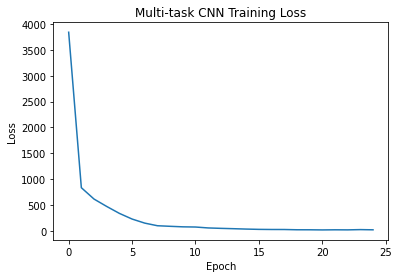

In [152]:
plt.plot(epoch_loss)
plt.title('Multi-task CNN Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.savefig('./Training_Loss_mtcnn.png')
plt.show()

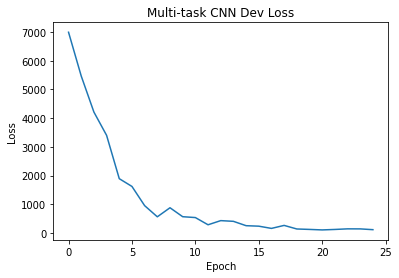

In [153]:
plt.plot(dev_epoch_loss)
plt.title('Multi-task CNN Dev Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.savefig('./Dev_Loss_mtcnn.png')
plt.show()

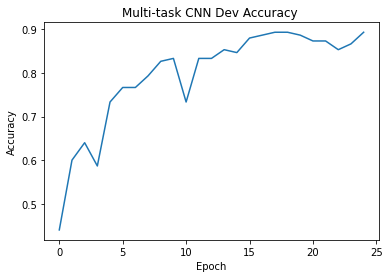

In [154]:
plt.plot(dev_accs)
plt.title('Multi-task CNN Dev Accuracy ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.savefig('./Dev_Acc_mtcnn.png')
plt.show()

In [155]:
mtl.eval()
mtl.model.eval()
pred_train = []
lab_train = []

for data in evalloader:
    feature, label, points = data
    feature = feature.view(1,3,350,350)
    feature, label,points = feature.to(device),label.to(device),points.to(device)

    ft = feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor)
    lb = label.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
    pt = points.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)



    lab_train.append(label)
    pred_train.append(torch.argmax(mtl.model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else 
                                                      torch.cuda.FloatTensor))[0]))

In [156]:
pred_train = np.array(pred_train)
lab_train = np.array(lab_train)
print("train set accuracy: " + str(np.sum(pred_train == lab_train) / len(lab_train)))

train set accuracy: 1.0


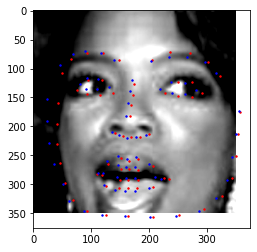

In [157]:

pred_dev = []
lab_dev = []
i = 0
for data in devloader:
    feature, label, points = data
    feature = feature.view(1,3,350,350)
    if i < 5:
      test_im = feature.view(3,350,350)[0]
      points_truth = points.squeeze()

    feature, label,points = feature.to(device),label.to(device),points.to(device)

    ft = feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor)
    lb = label.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
    pt = points.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
    res = mtl.model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor))
    
    if i <5:
      plt.figure()
      plt.imshow(test_im,cmap='gray', vmin=-1, vmax=1)
      pred_p = res[1].cpu().squeeze().detach().numpy()
      for i in range(68):
        plt.scatter(points_truth[i],points_truth[i+68],s=2,c='r')
        plt.scatter(pred_p[i],pred_p[i+68],s=2,c='b')

      i += 1
    #####


    lab_dev.append(label)
    pred_dev.append(torch.argmax(res[0]))

In [158]:
pred_dev = np.array(pred_dev)
lab_dev = np.array(lab_dev)
print("dev set accuracy: " + str(np.sum(pred_dev == lab_dev) / len(lab_dev)))

dev set accuracy: 0.8933333333333333


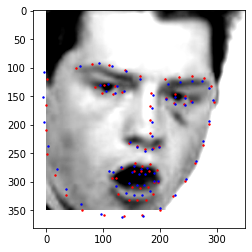

In [159]:
#Only run this when dev accuracy is best

pred_test = []
lab_test = []
i = 0
for data in testloader:
    feature, label, points = data
    feature = feature.view(1,3,350,350)
    if i < 5:
      test_im = feature.view(3,350,350)[0]
      points_truth = points.squeeze()

    feature, label,points = feature.to(device),label.to(device),points.to(device)

    ft = feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor)
    lb = label.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
    pt = points.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
    res = mtl.model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor))
    
    if i <5:
      plt.figure()
      plt.imshow(test_im,cmap='gray', vmin=-1, vmax=1)
      pred_p = res[1].cpu().squeeze().detach().numpy()
      for i in range(68):
        plt.scatter(points_truth[i],points_truth[i+68],s=2,c='r')
        plt.scatter(pred_p[i],pred_p[i+68],s=2,c='b')

      i += 1
    #####

  
    lab_test.append(label.to('cpu'))
    pred_test.append(torch.argmax(res[0]).to('cpu'))

In [160]:
pred_test = np.array(pred_test)
lab_test = np.array(lab_test)
print("test set accuracy: " + str(np.sum(pred_test == lab_test) / len(lab_test)))

test set accuracy: 0.86


In [161]:
conf_norm = normalize(confusion_matrix(lab_test,pred_test), norm="l1")
conf_norm = np.round(conf_norm, 2)
print(conf_norm)

[[0.96 0.   0.04 0.   0.  ]
 [0.02 0.8  0.1  0.02 0.05]
 [0.   0.05 0.86 0.05 0.05]
 [0.07 0.   0.07 0.82 0.04]
 [0.03 0.03 0.06 0.   0.87]]


In [165]:
torch.save(mtl,'./mt-cnn_fin_2.pt')

In [163]:
torch.save(mtl.model,'./mt-cnn_model-only.pt')

In [164]:
!ls drive/MyDrive/ML_Final/Models/mt-cnn.pt

drive/MyDrive/ML_Final/Models/mt-cnn.pt


In [166]:
!cp ./mt-cnn_fin_2.pt drive/MyDrive/ML_Final/Models/

In [167]:
!cp ./Dev_Acc_mtcnn.png drive/MyDrive/ML_Final/Figures/
!cp ./Dev_Loss_mtcnn.png drive/MyDrive/ML_Final/Figures/
!cp ./Training_Loss_mtcnn.png drive/MyDrive/ML_Final/Figures/

In [ ]:
# to load back up use this and use mtl.model.
mtl = torch.load('drive/MyDrive/ML_Final/Models/mt-cnn_fin.pt')